**Import Library**
---

In [1]:
# Import library
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import kagglehub
import os

**Data Understanding**
---



Data yang digunakan adalah dataset rating terhadap film dari MovieLens Latest Dataset (recommended for education and development) (URL: https://grouplens.org/datasets/movielens/).

In [2]:
# Download file zip dari URL
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip

# Ekstrak isi file ZIP
!unzip -o ml-latest-small.zip

--2025-06-11 13:49:00--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip.1’

ml-latest-small.zip 100%[===================>] 955.28K   978KB/s    in 1.0s    

2025-06-11 13:49:02 (978 KB/s) - ‘ml-latest-small.zip.1’ saved [978202/978202]

Archive:  ml-latest-small.zip
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


Selanjutnya, mari kita baca data-data di atas dengan menggunakan fungsi pandas.read_csv. Implementasikan kode berikut.

In [3]:
movies = pd.read_csv('ml-latest-small/movies.csv')
links = pd.read_csv('ml-latest-small/links.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

print('Jumlah data film: ', len(movies.movieId.unique()))
print('Jumlah data link film: ', len(links.movieId.unique()))
print('Jumlah data tag pada film yang diberikan pengguna: ', len(tags.tag.unique()))
print('Jumlah data penilaian yang diberikan pengguna: ', len(ratings))

Jumlah data film:  9742
Jumlah data link film:  9742
Jumlah data tag pada film yang diberikan pengguna:  1589
Jumlah data penilaian yang diberikan pengguna:  100836


Variabel-variabel pada MovieLens Latest Dataset adalah sebagai berikut:

- movies : merupakan metadata film
- links : merupakan ID link film di imdb.com dan themoviedb.com
- tags : merupakan tag pada film yang diberikan pengguna

Data yang terlihat relatif cukup sedikit, namun kita hanya akan mengambil sampel berdasarkan movieId dan userId dari ratings.csv. Selanjutnya, mari kita melakukan eksplorasi terhadap data dengan teknik univariate exploratory data analysis.

**EDA - Univariate Analysis (movies)**

Pertama, mari kita eksplorasi variabel movies, yaitu metadata film. Mari kita lihat kolom yang terdapat pada movies menggunakan fungsi info().

In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Berdasarkan output di atas, kita dapat mengetahui bahwa terdapat 9742 film yang ada pada dataset tersebut. Berikut adalah penjelasan dari kolom yang ada:
- `movieId` : identifier unik untuk setiap film
- `title` : judul film
- `genres` : genre film

Untuk melihat sampel datanya, mari kita terapkan fungsi head()

In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Berdasarkan output di atas, satu film bisa terdiri dari beberapa genre yang dipisahkan oleh tanda '|'. Untuk mengetahui ada genre apa saja pada data tersebut, terapkan kode berikut:

In [6]:
# Pecah genre berdasarkan '|', lalu flatten dan ambil yang unik
unique_genres = set()

for genre_list in movies['genres']:
    genres_split = genre_list.split('|')
    unique_genres.update(genres_split)

# Tampilkan hasil
print(f"Terdapat {len(unique_genres)} jenis genre:")
print(sorted(unique_genres))

Terdapat 20 jenis genre:
['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


Terdapat 20 jenis genre berbeda dengan nama genre seperti terlihat pada output kode. Perhatikanlah jenis-jenis genre di atas. Pada tahap selanjutnya kita akan gunakan data genre ini untuk memprediksi top-N rekomendasi bagi pengguna.

Naumn, terdapat nilai kolom genre = (no genres listed), artinya ada film yang genrenya tidak diketahui. Maka dari itu, kita akan memeriksa terlebih dahulu ada berapa film dengan kondisi tersebut. Terapkan kode berikut.

In [7]:
# Filter film yang tidak memiliki genre (no genres listed)
no_genre_movies = movies[movies['genres'] == '(no genres listed)']

# Tampilkan jumlah baris
print(f"Jumlah film yang tidak memiliki genre (no genres listed): {len(no_genre_movies)}")

Jumlah film yang tidak memiliki genre (no genres listed): 34


Jumlah 34 film jika dibandingkan dengan jumlah keseluruhan, yaitu 9742 film terbilang tidak signifikan. Maka dari itu, pada proses Data Preprocessing, data tersebut akan dihilangkan. Selanjutnya, kita eksplorasi variabel links, yaitu link dari film yang ada.

**EDA - Univariate Analysis (links)**

Kedua, mari kita eksplorasi variabel links, yaitu ID link film di imdb.com dan themoviedb.com. Mari kita lihat kolom yang terdapat pada links menggunakan fungsi info().

In [8]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


Berikut adalah penjelasan dari kolom yang ada:
- `movieId` : merupakan nilai identifier pada URL: https://movielens.org/movies/{movieId}
- `imdbId` :  merupakan nilai identifier pada URL: http://www.imdb.com/title/{imdbId}
- `tmdbId` : merupakan nilai identifier pada URL: https://www.themoviedb.org/movie/{tmdbId}.

Pada kolom tmdbId, terdapat 8 baris yang kosong, namun karena kolom ini tidak diikutsertakan dalam proses perhitungan, maka dapat kita biarkan saja. Untuk melihat sampel datanya, mari kita terapkan fungsi head().

In [9]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Berdasarkan output baris pertama, movieId = 1 memiliki link movielens https://movielens.org/movies/1, link imdb http://www.imdb.com/title/114709, dan link tmdb https://www.themoviedb.org/movie/862. Demikian seterusnya.

**EDA - Univariate Analysis (tags)**

Selanjutnya, kita eksplorasi variabel tags, yaitu tag pada film yang diberikan pengguna. Mari kita lihat kolom yang terdapat pada tags menggunakan fungsi info().

In [10]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


Berikut adalah penjelasan dari kolom yang ada:
- `userId` : merupakan user yang memberikan tag pada film
- `movieId` :  merupakan film yang diberi tag oleh user
- `tag` : merupakan tag yang diberikan oleh user
- `timestamp` : merupakan waktu ketika pengguna memberikan tag terhadap sebuah film. Nilainya berupa angka dalam format UNIX timestamp, yaitu jumlah detik sejak 1 Januari 1970 (epoch time)

Untuk melihat sampel datanya, mari kita terapkan fungsi head()

In [11]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


Baris ke-1 dari output di atas memberikan arti bahwa user dengan userId = 2 memberikan tag 'funny' ke film dengan movieId = 60756 pada 24 Oktober 2015 pukul 14:49:54 UTC (setelah dikonversi dari UNIX timestamp).

Selanjutnya, kita eksplorasi variabel user. Namun, pada dataset ini user tidak memiliki file .csv nya sendiri. Pada ratings.csv, terdapat kolom userId, kolom ini akan kita gunakan untuk mengidentifikasi jumlah user yang telah memberikan rating terhadap film. Terapkan kode berikut.

**EDA - Univariate Analysis (user)**

In [12]:
print('Jumlah user yang memberikan rating: ', len(ratings.userId.unique()))

Jumlah user yang memberikan rating:  610


Berdasarkan output di atas, diketahui terdapat 610 user yang telah memberikan rating terhadap film. Data ini akan digunakan untuk tahap modelling dengan Collaborative Filtering.

Pada tahap modelling dengan Content-Based Filtering nanti, data yang dibutuhkan adalah judul film dan genre. Kita akan menghitung kesamaan (similarity) genre dan judul film kemudian membuat rekomendasi berdasarkan kesamaan ini.

**EDA - Univariate Analysis (ratings)**

Selanjutnya, mari kita eksplorasi data yang akan kita gunakan pada model yaitu data ratings. Pertama, kita lihat seperti apa data pada variabel rating dengan fungsi head().

In [13]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Dari fungsi rating.head(), kita dapat mengetahui bahwa data rating terdiri dari 4 kolom. Kolom-kolom tersebut antara lain:

- `userId` : merupakan ID user
- `movieId` : merupakan ID film
- `rating` : merupakan data rating yang diberikan user terhadap film
- `timestamp` : merupakan waktu ketika pengguna memberikan rating terhadap sebuah film. Nilainya berupa angka dalam format UNIX timestamp, yaitu jumlah detik sejak 1 Januari 1970 (epoch time)

Untuk melihat distribusi rating pada data, gunakan fungsi describe() dengan menerapkan kode berikut:

In [14]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Dari output di atas, diketahui bahwa terdapat 100836 total rating dan nilai maksimum rating adalah 5 dan nilai minimumnya adalah 0.5. Artinya, skala rating berkisar antara 0.5 hingga 5.

Sampai di tahap ini, kita telah memahami variabel-variabel pada data yang kita miliki.

**Data Preprocessing - Memeriksa Missing Value pada Rating**

Untuk memeriksa apakah terdapat missing value, jalankan kode berikut.

In [15]:
# Cek missing value dengan fungsi isnull()
ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0


Tidak ada missing value yang ditemukan, kita dapat lanjut ke tahap berikutnya.

**Data Preprocessing - Menggabungkan Data Rating dengan Fitur Genre Film**

Langkah selanjutnya adalah menggabungkan variabel ratings dengan variabel movies, yaitu metadata film yang mengandung judul film dan genrenya. Implementasikan kode berikut.

In [16]:
# Menggabungkan dataframe ratings dengan movies dan memasukkannya ke dalam variabel movies_ratings
movies_ratings = pd.merge(ratings, movies, on='movieId', how='left')
movies_ratings

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


Inilah data yang akan kita gunakan untuk membuat sistem rekomendasi. Namun, sebagai trivia, kita akan mencari tahu film apa yang memiliki rating tertinggi, jalankan kode berikut:

In [17]:
movies_ratings[['movieId', 'title', 'rating']].groupby(['movieId', 'title']).sum().reset_index().sort_values(by='rating', ascending=False)

,movieId,title,rating
277,318,"Shawshank Redemption, The (1994)",1404.0
314,356,Forrest Gump (1994),1370.0
257,296,Pulp Fiction (1994),1288.5
1938,2571,"Matrix, The (1999)",1165.5
510,593,"Silence of the Lambs, The (1991)",1161.0
...,...,...,...
6646,57326,In the Name of the King: A Dungeon Siege Tale ...,0.5
6528,54768,Daddy Day Camp (2007),0.5
6537,54934,"Brothers Solomon, The (2007)",0.5
8966,138798,Joe Dirt 2: Beautiful Loser (2015),0.5


Film yang paling banyak mendapatkan rating adalah film The Shawshank Redemption (1994) dengan jumlah rating 1404. Sebaliknya, film yang paling sedikit mendapatkan jumlah rating adalah fillm Lionheart (1990) dengan jumlah rating 0.5.

Berikutnya, mari kita menuju tahapan Data Preparation.

**Data Preparation**
---



**Mengatasi Missing Value**

Pada tahap EDA - Univariate Analysis (movies), kita mendapat informasi 'Jumlah film yang tidak memiliki genre (no genres listed): 34'. Informasi tersebut akan kita tangani dalam tahap ini, yaitu dengan cara menghapus baris yang memiliki genre '(no genres listed)'. Terapkan kode berikut.

In [19]:
# Drop baris dengan 'genres' = '(no genres listed)'
movies_ratings = movies_ratings[movies_ratings['genres'] != '(no genres listed)']
movies_ratings

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


Perhatikanlah, setelah sebelumnya data movies_ratings memiliki 100836 baris, sekarang menjadi 100789 baris.

Mari kita cek lagi datanya apakah ada missing value atau tidak. Jalankan kode berikut.

In [20]:
# Mengecek missing value pada dataframe movies_ratings
movies_ratings.isnull().sum()

,0
userId,0
movieId,0
rating,0
timestamp,0
title,0
genres,0


Ok, sekarang data kita sudah bersih. Mari lanjutkan ke tahap berikutnya!

Dalam sistem rekomendasi yang kita kembangkan, penting untuk memastikan satu film memiliki satu baris nilai genre (bisa terdiri dari satu genre atau beberapa genre yang dipisahkan oleh tanda '|'). Tujuannya supaya tidak terjadi dobel atau rangkap kategori dalam satu film. Sehingga, sistem dapat merekomendasikan film berdasarkan genre-nya.

Berikutnya, kita bisa melanjutkan ke tahap persiapan. Buatlah variabel bernama preparation. Jalankan kode berikut.

In [21]:
# Membuat variabel preparation yang berisi dataframe movies_ratings kemudian mengurutkan berdasarkan movieId
preparation = movies_ratings
preparation.sort_values('movieId')

,userId,movieId,rating,timestamp,title,genres
72453,469,1,4.0,965336888,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
89904,584,1,5.0,834987643,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
60405,391,1,3.0,1032388077,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
83535,533,1,5.0,1424753740,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
56878,380,1,5.0,1493420345,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
27256,184,193581,4.0,1537109082,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
27257,184,193583,3.5,1537109545,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
27258,184,193585,3.5,1537109805,Flint (2017),Drama
27259,184,193587,3.5,1537110021,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Selanjutnya, kita hanya akan menggunakan data unik untuk dimasukkan ke dalam proses pemodelan. Oleh karena itu, kita perlu menghapus data yang duplikat dengan fungsi drop_duplicates(). Dalam hal ini, kita membuang data duplikat pada kolom ‘movieId’. Implementasikan kode berikut.

In [22]:
# Membuang data duplikat pada variabel preparation
preparation = preparation.drop_duplicates('movieId')
preparation

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100820,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100821,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100823,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100827,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


Selanjutnya, kita perlu melakukan konversi data series menjadi list. Dalam hal ini, kita menggunakan fungsi tolist() dari library numpy. Implementasikan kode berikut.

In [23]:
# Mengonversi data series ‘movieId’ menjadi dalam bentuk list
movie_id = preparation['movieId'].tolist()

# Mengonversi data series ‘title’ menjadi dalam bentuk list
movie_title = preparation['title'].tolist()

# Mengonversi data series ‘genres’ menjadi dalam bentuk list
movie_genres = preparation['genres'].tolist()

print(len(movie_id))
print(len(movie_title))
print(len(movie_genres))

9690
9690
9690


Tahap berikutnya, kita akan membuat dictionary untuk menentukan pasangan key-value pada data movie_id, movie_title, dan movie_genres yang telah kita siapkan sebelumnya.

In [24]:
# Membuat dictionary untuk data ‘resto_id’, ‘resto_name’, dan ‘cuisine’
movie_new = pd.DataFrame({
    'id': movie_id,
    'movie_title': movie_title,
    'movie_genres': movie_genres
})
movie_new

,id,movie_title,movie_genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,3,Grumpier Old Men (1995),Comedy|Romance
2,6,Heat (1995),Action|Crime|Thriller
3,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...
9685,160341,Bloodmoon (1997),Action|Thriller
9686,160527,Sympathy for the Underdog (1971),Action|Crime|Drama
9687,160836,Hazard (2005),Action|Drama|Thriller
9688,163937,Blair Witch (2016),Horror|Thriller


Selamat! Data kini telah siap untuk dimasukkan ke dalam pemodelan. Yuk, kita lanjut ke tahap berikutnya!

**Modelling - Content Based Filtering**
---

Sampai di sini, Anda telah melewati serangkaian tahapan untuk membuat sistem rekomendasi mulai dari:

1. Data Understanding.
2. Univariate Exploratory Data Analysis.
3. Data Preprocessing.
4. Data Preparation.

Kini, saatnya Anda mengembangkan sistem rekomendasi dengan pendekatan content based filtering. Tapi sebelumnya, mari cek lagi data yang kita miliki dan assign dataframe dari tahap sebelumnya ke dalam variabel data, sebagai berikut:

In [25]:
data = movie_new
data.sample(5)

,id,movie_title,movie_genres
49,1009,Escape to Witch Mountain (1975),Adventure|Children|Fantasy
6196,5076,"Adventures of Huck Finn, The (1993)",Adventure|Children|Comedy|Drama
9309,25923,Great Expectations (1946),Drama
8609,6821,More American Graffiti (1979),Comedy
1897,45672,Click (2006),Adventure|Comedy|Drama|Fantasy|Romance


**TF-IDF Vectorizer**

Pada tahap ini, kita akan membangun sistem rekomendasi sederhana berdasarkan jenis masakan yang disediakan restoran. Anda telah belajar mengenai TF-IDF Vectorizer pada modul Sentiment Analysis. Teknik tersebut juga akan digunakan pada sistem rekomendasi untuk menemukan representasi fitur penting dari setiap kategori masakan.

Sama seperti proyek sentiment analysis, pada proyek ini, kita juga menggunakan fungsi tfidfvectorizer() dari library sklearn. Jalankan kode berikut

In [26]:
# Inisialisasi TfidfVectorizer
vectorizer = TfidfVectorizer()

# Melakukan perhitungan idf pada data genres
vectorizer.fit(data['movie_genres'])

# Mapping array dari fitur index integer ke fitur nama
vectorizer.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'fi', 'film', 'horror', 'imax',
       'musical', 'mystery', 'noir', 'romance', 'sci', 'thriller', 'war',
       'western'], dtype=object)

Selanjutnya, lakukan fit dan transformasi ke dalam bentuk matriks.

In [27]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = vectorizer.fit_transform(data['movie_genres'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(9690, 21)

Perhatikanlah, matriks yang kita miliki berukuran (9690, 21). Nilai 9690 merupakan ukuran data dan 21 merupakan matriks genre.

Untuk menghasilkan vektor tf-idf dalam bentuk matriks, kita menggunakan fungsi todense(). Jalankan kode berikut.

In [28]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.41677501, 0.51640289, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.54892995, 0.        , 0.        , ..., 0.54217851, 0.        ,
         0.        ],
        ...,
        [0.64131101, 0.        , 0.        , ..., 0.63342334, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.6246757 , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

Selanjutnya, mari kita lihat matriks tf-idf untuk beberapa film (movie_title) dan genre film (genres). Terapkan kode berikut.

In [29]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan genre film
# Baris diisi dengan judul film

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=vectorizer.get_feature_names_out(),
    index=data.movie_title
).sample(21, axis=1).sample(10, axis=0)

,crime,musical,western,imax,horror,thriller,mystery,action,noir,documentary,...,drama,war,adventure,comedy,film,fi,animation,sci,fantasy,romance
movie_title,,,,,,,,,,,,,,,,,,,,,
Swelter (2014),0.0,0.0,0.0,0.0,0.000000,0.633423,0.000000,0.641311,0.0,0.0,...,0.433007,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
Ruby in Paradise (1993),0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,1.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
Coffee Town (2013),0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
"Yes Men, The (2003)",0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
La Belle Verte (1996),0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
"Fallen Idol, The (1948)",0.0,0.0,0.0,0.0,0.000000,0.528771,0.767947,0.000000,0.0,0.0,...,0.361467,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
This Is the End (2013),0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.807521,0.0,0.0,...,0.000000,0.0,0.000000,0.589839,0.0,0.000000,0.0,0.000000,0.0,0.0
Star Trek Beyond (2016),0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.432736,0.0,0.0,...,0.000000,0.0,0.492807,0.000000,0.0,0.533798,0.0,0.533798,0.0,0.0
Parasyte: Part 2 (2015),0.0,0.0,0.0,0.0,0.577708,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.577171,0.0,0.577171,0.0,0.0


Output matriks tf-idf di atas menunjukkan Shut Up & Sing (2006) memiliki genre documentary. Hal ini terlihat dari nilai matriks 1.0 pada kategori drama. Selanjutnya, film Wall Street (1987) termasuk dalam genre drama. Sedangkan, film I Spy (2002) menunjukkan nilai tf-idf sebesar 0.567291 untuk genre crime, 0.557442 untuk adventure, dan 0.489493 untuk action. Ini menunjukkan bahwa film ini berisi ketiga genre tersebut, dengan dominasi yang cukup seimbang.

Demikian seterusnya, matriks tf-idf ini memudahkan kita dalam menganalisis seberapa kuat keterkaitan antara film dan masing-masing genre, serta memungkinkan kita mengelompokkan film berdasarkan kedekatan nilai tf-idf antar genre.

**Cosine Similarity**

Pada tahap sebelumnya, kita telah berhasil mengidentifikasi korelasi antara restoran dengan kategori masakannya. Sekarang, kita akan menghitung derajat kesamaan (similarity degree) antar restoran dengan teknik cosine similarity. Di sini, kita menggunakan fungsi cosine_similarity dari library sklearn.

Jalankan kode berikut:

In [30]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.15245713, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15245713, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.69546334, 0.33868574,
        0.        ],
       ...,
       [0.        , 0.        , 0.69546334, ..., 1.        , 0.39568417,
        0.        ],
       [0.        , 0.        , 0.33868574, ..., 0.39568417, 1.        ,
        0.78088428],
       [0.        , 0.        , 0.        , ..., 0.        , 0.78088428,
        1.        ]])

Pada tahapan ini, kita menghitung cosine similarity dataframe tfidf_matrix yang kita peroleh pada tahapan sebelumnya. Dengan satu baris kode untuk memanggil fungsi cosine similarity dari library sklearn, kita telah berhasil menghitung kesamaan (similarity) antar film. Kode di atas menghasilkan keluaran berupa matriks kesamaan dalam bentuk array.

Selanjutnya, mari kita lihat matriks kesamaan setiap film dengan menampilkan judul film dalam 5 sampel kolom (axis = 1) dan 10 sampel baris (axis=0). Jalankan kode berikut.

In [31]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa judul film
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['movie_title'], columns=data['movie_title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap film
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9690, 9690)


movie_title,It's a Very Merry Muppet Christmas Movie (2002),12 Chairs (1971),Drive Me Crazy (1999),"Way of the Dragon, The (a.k.a. Return of the Dragon) (Meng long guo jiang) (1972)",Heartless (2009)
movie_title,,,,,
"Last Seduction, The (1994)",0.000000,0.000000,0.000000,0.526772,0.233336
Cradle Will Rock (1999),0.000000,0.000000,0.000000,0.000000,0.000000
Return with Honor (1998),0.000000,0.000000,0.000000,0.000000,0.000000
Platoon (1986),0.000000,0.000000,0.000000,0.000000,0.000000
"Day of the Locust, The (1975)",0.000000,0.000000,0.000000,0.000000,0.000000
The Dark Tower (2017),0.000000,0.000000,0.000000,0.000000,0.413621
Tigerland (2000),0.000000,0.000000,0.000000,0.000000,0.000000
"Silence, The (Tystnaden) (1963)",0.000000,0.000000,0.000000,0.000000,0.000000
Opera (1987),0.000000,0.000000,0.000000,0.395372,0.643067


Dengan cosine similarity, kita berhasil mengidentifikasi kesamaan antara satu film dengan film lainnya. Shape (9690, 9690) merupakan ukuran matriks similarity dari data yang kita miliki. Berdasarkan data yang ada, matriks di atas sebenarnya berukuran 9690 film x 9690 film (masing-masing dalam sumbu X dan Y). Artinya, kita mengidentifikasi tingkat kesamaan pada 9690 nama film. Tapi tentu kita tidak bisa menampilkan semuanya. Oleh karena itu, kita hanya memilih 10 film pada baris vertikal dan 5 film pada sumbu horizontal seperti pada contoh di atas.

Nah, dengan data kesamaan (similarity) film yang diperoleh dari kode sebelumnya, kita akan merekomendasikan daftar film yang mirip (similar) dengan film yang sebelumnya pernah ditonton pengguna.

**Mendapatkan Rekomendasi**

Sebelumnya, kita telah memiliki data similarity (kesamaan) antar film. Kini, tibalah saatnya  menghasilkan sejumlah film yang akan direkomendasikan kepada user. Untuk lebih memahami bagaimana cara kerjanya, lihatlah kembali matriks similarity pada tahap sebelumnya. Sebagai gambaran, mari kita ambil satu contoh berikut.

User X pernah menonton film X. Kemudian, saat user tersebut berencana untuk menonton film lain, sistem akan merekomendasikan film Y. Nah, rekomendasi film ini berdasarkan kesamaan yang dihitung dengan cosine similarity pada tahap sebelumnya.

Di sini, kita membuat fungsi resto_recommendations dengan beberapa parameter sebagai berikut:

- judul_film : judul film (index kemiripan dataframe).
- similarity_data : dataframe mengenai similarity yang telah kita definisikan sebelumnya.
- items : Nama dan fitur yang digunakan untuk mendefinisikan kemiripan, dalam hal ini adalah ‘movie_title’ dan ‘genres’.
- k : Banyak rekomendasi yang ingin diberikan.

Sebelum mulai menulis kodenya, ingatlah kembali definisi sistem rekomendasi yang menyatakan bahwa keluaran sistem ini adalah berupa top-N recommendation. Oleh karena itu, kita akan memberikan sejumlah rekomendasi film pada pengguna yang diatur dalam parameter k (dalam hal ini k=5, artinya kita akan merekomendasikan 5 film kepada user).

Jalankan kode berikut.

In [32]:
def movie_recommendations(judul_film, similarity_data=cosine_sim_df, items=data[['movie_title', 'movie_genres']], k=5):
    """
    Rekomendasi film berdasarkan kemiripan dataframe

    Parameter:
    ---
    judul_film : tipe data string (str)
                Judul film (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan judul film sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """

    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,judul_film].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop judul_film agar judul film yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(judul_film, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Perhatikanlah, dengan menggunakan argpartition, kita mengambil sejumlah nilai k tertinggi dari similarity data (dalam kasus ini: dataframe cosine_sim_df). Kemudian, kita mengambil data dari bobot (tingkat kesamaan) tertinggi ke terendah. Data ini dimasukkan ke dalam variabel closest. Berikutnya, kita perlu menghapus judul_film yang yang dicari agar tidak muncul dalam daftar rekomendasi. Dalam kasus ini, nanti kita akan mencari film yang mirip dengan Toy Story (1995), sehingga kita perlu drop judul_film Toy Story (1995) agar tidak muncul dalam daftar rekomendasi yang diberikan nanti.  

Selanjutnya, mari kita terapkan kode di atas untuk menemukan rekomendasi film yang mirip dengan Toy Story (1995). Terapkan kode berikut:

In [33]:
data[data.movie_title.eq('Toy Story (1995)')]

,id,movie_title,movie_genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


Perhatikanlah, Toy Story (1995) masuk dalam genre 'Adventure|Animation|Children|Comedy|Fantasy'. Tentu kita berharap rekomendasi yang diberikan adalah film dengan genre yang mirip. Nah, sekarang, dapatkan movie recommendation dengan memanggil fungsi yang telah kita definisikan sebelumnya:

In [34]:
# Mendapatkan rekomendasi film yang mirip dengan Toy Story (1995)
movie_recommendations('Toy Story (1995)')

,movie_title,movie_genres
0,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
1,Moana (2016),Adventure|Animation|Children|Comedy|Fantasy
2,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy
3,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy
4,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy


Berhasil, sistem kita memberikan rekomendasi 4 judul film dengan genre Adventure|Animation|Children|Comedy|Fantasy.

**Modelling - Collaborative Filtering**
---

**Data Understanding**

Pahami terlebih dahulu data rating yang kita miliki. Ingatlah saat kita melakukan load data di awal dan membaca file rating_final.csv. Saat itu, kita membuat variabel rating dan menetapkan data pada variabel tersebut. Kemudian, kita menghapus rating pada data film dengan genres = '(no_genres_listed)' dan menyimpannya dalam variabel movies_ratings. Untuk memudahkan supaya tidak tertukar dengan fitur ‘rating’ pada data, kita ubah nama variabel movies_ratings (tanpa kolom genres dan title) menjadi variabel df.

In [36]:
# Membaca dataset

df = movies_ratings.drop(['genres', 'title'], axis=1)
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Perhatikanlah, data rating memiliki 100789 baris dan 4 kolom.

**Data Preparation**

Sekarang kita memasuki tahap preprocessing. Pada tahap ini, kita perlu melakukan persiapan data untuk menyandikan (encode) fitur ‘userId’ dan ‘movieId’ ke dalam indeks integer. Terapkan kode berikut.

In [37]:
# Mengubah userId menjadi list tanpa nilai yang sama
user_ids = df['userId'].unique().tolist()
print('list userId: ', user_ids)

# Melakukan encoding userId
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded userId : ', user_to_user_encoded)

# Melakukan proses encoding angka ke ke userId
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userId: ', user_encoded_to_user)

list userId:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

Selanjutnya, lakukan hal yang sama pada fitur ‘movieId’.

In [38]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movie_ids = df['movieId'].unique().tolist()

# Melakukan proses encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# Melakukan proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

Berikutnya, petakan userId dan movieId ke dataframe yang berkaitan.

In [39]:
# Mapping userId ke dataframe user
df['user'] = df['userId'].map(user_to_user_encoded)

# Mapping movieId ke dataframe movie
df['movie'] = df['movieId'].map(movie_to_movie_encoded)

Terakhir, cek beberapa hal dalam data seperti jumlah user, jumlah film, dan mengubah nilai rating menjadi float.

In [40]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah film
num_movie = len(movie_to_movie_encoded)
print(num_movie)

# Mengubah rating menjadi nilai float
df['rating'] = df['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(df['rating'])

# Nilai maksimal rating
max_rating = max(df['rating'])

print('Number of User: {}, Number of Movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

610
9690
Number of User: 610, Number of Movie: 9690, Min Rating: 0.5, Max Rating: 5.0


Tahap persiapan telah selesai. Berikut adalah hal-hal yang telah kita lakukan pada tahap ini:

- Memahami data rating yang kita miliki.
- Menyandikan (encode) fitur ‘userId’ dan ‘movieId’ ke dalam indeks integer.
- Memetakan ‘userID’ dan ‘movieId’ ke dataframe yang berkaitan.
- Mengecek beberapa hal dalam data seperti jumlah user, jumlah film, kemudian mengubah nilai rating menjadi float.

Tahap persiapan ini penting dilakukan agar data siap digunakan untuk
pemodelan. Namun sebelumnya, kita perlu membagi data untuk training dan validasi terlebih dahulu.

**Membagi Data untuk Training dan Validasi**

Sebelum membagi data menjadi data training dan validasi, datanya perlu diacak terlebih dahulu agar distribusinya menjadi random.

- frac=1 berarti "fraction" = 100% dari data diambil, tapi urutannya diacak.
- random_state=42 berarti menetapkan seed untuk pengacakan, agar hasil acakan selalu sama setiap kali dijalankan. Angka 42 bisa diganti berapa pun, tapi disarankan untuk tetap konsisten agar replikasi bisa dilakukan.

In [41]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df

,userId,movieId,rating,timestamp,user,movie
980,7,8665,3.5,1108602755,6,783
64486,414,42728,3.5,1163775855,413,5917
80543,509,6377,3.5,1435992322,508,875
50593,326,85342,4.5,1322252028,325,5844
64557,414,48304,4.0,1184683869,413,1049
...,...,...,...,...,...,...
6266,42,4007,5.0,996258563,41,1189
54910,365,508,2.0,1488594826,364,656
76849,480,7376,1.0,1179165684,479,5869
860,6,981,3.0,845556567,5,712


Selanjutnya, kita bagi data train dan validasi dengan komposisi 80:20. Namun sebelumnya, kita perlu memetakan (mapping) data user dan film menjadi satu value terlebih dahulu. Lalu, buatlah rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training.

In [42]:
# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu value
x = df[['user', 'movie']].values

# Membuat variabel y untuk membuat rating dari hasil
y = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[   6  783]
 [ 413 5917]
 [ 508  875]
 ...
 [ 479 5869]
 [   5  712]
 [ 102 1129]] [0.66666667 0.66666667 0.66666667 ... 0.11111111 0.55555556 0.88888889]


Data telah siap untuk dimasukkan ke dalam model.

**Evaluasi**
---

Pada tahap ini, model menghitung skor kecocokan antara user dan film dengan teknik embedding. Pertama, kita melakukan proses embedding terhadap data user dan film. Selanjutnya, lakukan operasi perkalian dot product antara embedding user dan film. Selain itu, kita juga dapat menambahkan bias untuk setiap user dan film. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.

Di sini, kita membuat class RecommenderNet dengan keras Model class. Kode class RecommenderNet ini terinspirasi dari tutorial dalam situs Keras dengan beberapa adaptasi sesuai kasus yang sedang kita selesaikan. Terapkan kode berikut.

In [43]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_resto, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_resto = num_resto
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.resto_embedding = layers.Embedding( # layer embeddings resto
        num_resto,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.resto_bias = layers.Embedding(num_resto, 1) # layer embedding resto bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    resto_vector = self.resto_embedding(inputs[:, 1]) # memanggil layer embedding 3
    resto_bias = self.resto_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2)

    x = dot_user_resto + user_bias + resto_bias

    return tf.nn.sigmoid(x) # activation sigmoid

Selanjutnya, lakukan proses compile terhadap model.

In [44]:
model = RecommenderNet(num_users, num_movie, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Model ini menggunakan Binary Crossentropy untuk menghitung loss function, Adam (Adaptive Moment Estimation) sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation.

Langkah berikutnya, mulailah proses training.

In [45]:
# Memulai training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 25,
    validation_data = (x_val, y_val)
)

Epoch 1/25
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.6546 - root_mean_squared_error: 0.2503 - val_loss: 0.6162 - val_root_mean_squared_error: 0.2102
Epoch 2/25
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.6117 - root_mean_squared_error: 0.2076 - val_loss: 0.6120 - val_root_mean_squared_error: 0.2054
Epoch 3/25
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 0.6078 - root_mean_squared_error: 0.2029 - val_loss: 0.6086 - val_root_mean_squared_error: 0.2015
Epoch 4/25
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - loss: 0.6047 - root_mean_squared_error: 0.1981 - val_loss: 0.6082 - val_root_mean_squared_error: 0.2010
Epoch 5/25
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 38s 7ms/step - loss: 0.6035 - root_mean_squared_error: 0.1972 - val_loss: 0.6070 - val_root_mean_squared_error: 0.1996
Epoch 6/25
2520/2520 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.6029 - root_mean_squared_error: 0.1958 - val_loss: 0.6067 - val_root_mean_squared_error: 0.1991
Epoch 7/25
2520/2520 ━━━━━━━━━━━━

**Visualisasi Metrik**

Untuk melihat visualisasi proses training, mari kita plot metrik evaluasi dengan matplotlib. Terapkan kode berikut.

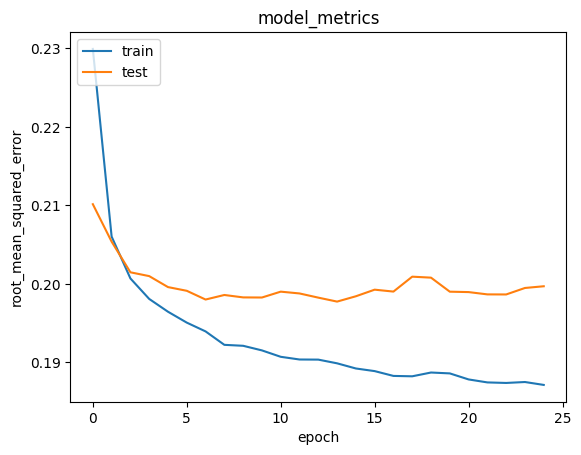

In [46]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Perhatikanlah, proses training model cukup smooth dan model konvergen pada epochs sekitar 100. Dari proses ini, kita memperoleh nilai error akhir sebesar sekitar 0.23 dan error pada data validasi sebesar sekitar 0.34. Nilai tersebut cukup bagus untuk sistem rekomendasi. Mari kita cek, apakah model ini bisa membuat rekomendasi dengan baik?

**Mendapatkan Rekomendasi Film**

Untuk mendapatkan rekomendasi film, pertama kita ambil sampel user secara acak dan definisikan variabel movie_not_watched yang merupakan daftar film yang belum pernah ditonton oleh user. Daftar movie_not_watched inilah yang akan menjadi film yang kita rekomendasikan.

Sebelumnya, user telah memberi rating pada beberapa film yang telah mereka tonton. Kita menggunakan rating ini untuk membuat rekomendasi film yang mungkin cocok untuk user. Nah, film yang akan direkomendasikan tentulah film yang belum pernah ditonton oleh user. Oleh karena itu, kita perlu membuat variabel movie_not_watched sebagai daftar film untuk direkomendasikan pada user.

Variabel movie_not_watched diperoleh dengan menggunakan operator bitwise (~) pada variabel movie_watched_by_user.

Terapkan kode berikut.

In [48]:
movie_df = movie_new
df = movies_ratings.drop(['genres', 'title'], axis=1)

# Mengambil sample user
user_id = df.userId.sample(1).iloc[0]
movie_watched_by_user = df[df.userId == user_id]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
movie_not_watched = movie_df[~movie_df['id'].isin(movie_watched_by_user.movieId.values)]['id']
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_to_movie_encoded.keys()))
)

movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)

Selanjutnya, untuk memperoleh rekomendasi restoran, gunakan fungsi model.predict() dari library Keras dengan menerapkan kode berikut.

In [49]:
ratings = model.predict(user_movie_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Movies with high ratings from user')
print('----' * 8)

top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

movie_df_rows = movie_df[movie_df['id'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.movie_title, ':', row.movie_genres)

print('----' * 8)
print('Top 10 Movies Recommendation')
print('----' * 8)

recommended_movie = movie_df[movie_df['id'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.movie_title, ':', row.movie_genres)

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Showing recommendations for users: 606
Movies with high ratings from user
--------------------------------
Pulp Fiction (1994) : Comedy|Crime|Drama|Thriller
Eat Drink Man Woman (Yin shi nan nu) (1994) : Comedy|Drama|Romance
Nausicaä of the Valley of the Wind (Kaze no tani no Naushika) (1984) : Adventure|Animation|Drama|Fantasy|Sci-Fi
Best of Youth, The (La meglio gioventù) (2003) : Drama
Pride and Prejudice (1940) : Comedy|Drama|Romance
--------------------------------
Top 10 Movies Recommendation
--------------------------------
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama
Gallipoli (1981) : Drama|War
Streetcar Named Desire, A (1951) : Drama
His Girl Friday (1940) : Comedy|Romance
Trial, The (Procès, Le) (1962) : Drama
Captain Fantastic (2016) : Drama
Paperman (2012) : Animation|Comedy|Romance
Paths of Glory (1957) : Drama|War
Stranger Than Paradise (1984) : Comedy|Drama
Day of the Doctor, The (2013) : Adventure|Drama|Sci-Fi


Selamat! Anda telah berhasil memberikan rekomendasi kepada user. Sebagai contoh, hasil di atas adalah rekomendasi untuk user dengan id U1013. Dari output tersebut, kita dapat membandingkan antara Resto with high ratings from user dan Top 10 resto recommendation untuk user.

Perhatikanlah, beberapa restoran rekomendasi menyediakan kategori masakan (cuisine) yang sesuai dengan rating user. Kita memperoleh 3 rekomendasi resto dengan kategori ‘cuisine’ Mexican, 2 rekomendasi resto dengan kategori Cafetaria, 1 rekomendasi resto dengan kategori Bar_Pub_Brewery, 1 rekomendasi resto dengan kategori International, 1 rekomendasi resto dengan kategori Japanese, 1 rekomendasi resto dengan kategori Bar, dan 1 resto dengan kategori Contemporary.

Prediksinya cukup sesuai, bukan?

Sampai di tahap ini, Anda telah berhasil membuat sistem rekomendasi dengan dua teknik, yaitu Content based Filtering dan Collaborative Filtering. Sistem rekomendasi yang Anda buat telah berhasil memberikan sejumlah rekomendasi restoran yang sesuai dengan preferensi pengguna.

Ingatlah, setiap teknik membutuhkan data yang berbeda dan bekerja dengan cara yang berbeda pula. Misalnya, pada teknik collaborative filtering, Anda membutuhkan data rating dari pengguna. Sedangkan, pada content based filtering, data rating tidak diperlukan.

Jika Anda masih penasaran untuk mencoba membuat sistem rekomendasi dengan data lain atau teknik lain, jangan ragu untuk mencoba, ya!